In [2]:
import scispacy
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import zipfile
import os
import xmltodict
import json
import zlib
import seaborn as sns
import resource
import sys
import regex as re
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
import nltk.data
import time
import json
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from numpy.testing import assert_array_equal
import threading
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from mlxtend.preprocessing import TransactionEncoder
from datasketch import MinHash, MinHashLSH
#nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

### Increase Recursion Depth

In [2]:
print (resource.getrlimit(resource.RLIMIT_STACK))
print (sys.getrecursionlimit())

max_rec = 0x100000

resource.setrlimit(resource.RLIMIT_STACK, [0x100 * max_rec, resource.RLIM_INFINITY])
sys.setrecursionlimit(max_rec)

(8388608, -1)
3000


## Step 1: Explore the Dataset

In [3]:
article_df = pd.read_hdf('data/nature/preprocessed/article_df.hdf')

In [3]:
article_df

,ArticleID,DOI,Issue,Volume,PageEnd,PageStart,PubYear,SortDate,Title,Type,Journal
0,048485a0,10.1038/048485a0,1247.0,48.0,508.0,485.0,1893,1893-09-21,The British Association,ed,Nature
1,048508a0,10.1038/048508a0,1247.0,48.0,509.0,508.0,1893,1893-09-21,The Thieving of Assyrian Antiquities\r\n,lt,Nature
2,048509a0,10.1038/048509a0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Bishop's Ring\r\n,lt,Nature
3,048509b0,10.1038/048509b0,1247.0,48.0,509.0,509.0,1893,1893-09-21,Spring and Autumn of 1893\r\n,lt,Nature
4,048509c0,10.1038/048509c0,1247.0,48.0,512.0,509.0,1893,1893-09-21,Notes,misc,Nature
...,...,...,...,...,...,...,...,...,...,...,...
395498,149145b0,10.1038/149145b0,3770.0,149.0,146.0,145.0,1942,1942-01-31,NATIVE SUBSISTENCE ON THE AMERICAN CENTRAL PLAINS,nw,Nature
395499,149146a0,10.1038/149146a0,3770.0,149.0,146.0,146.0,1942,1942-01-31,EARTHQUAKE ORIGINS IN THE NEW ZEALAND REGION,nw,Nature
395500,149146b0,10.1038/149146b0,3770.0,149.0,146.0,146.0,1942,1942-01-31,FORTHCOMING EVENTS,misc,Nature
395501,149146c0,10.1038/149146c0,3770.0,149.0,146.0,146.0,1942,1942-01-31,APPOINTMENTS VACANT,misc,Nature


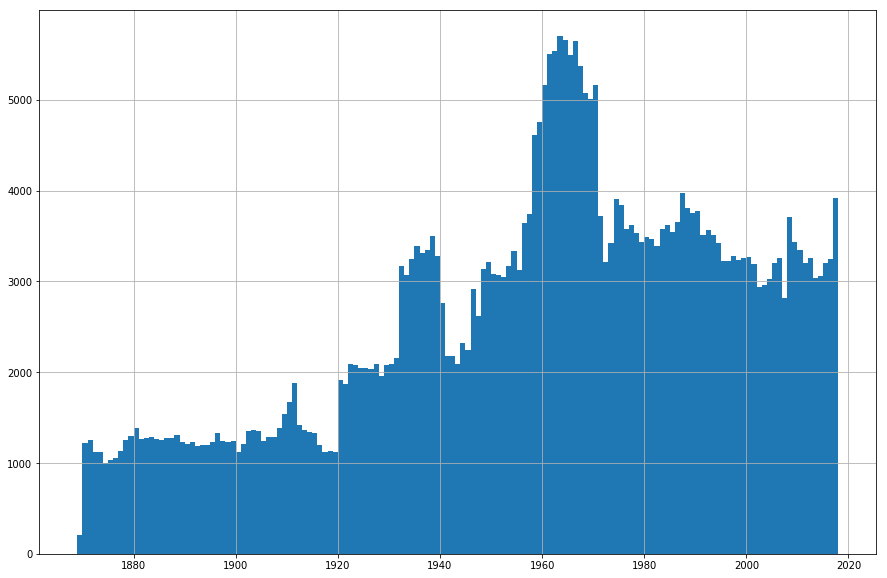

In [4]:
article_df['PubYear'].hist(bins = (article_df['PubYear'].max() - article_df['PubYear'].min()), figsize = (15, 10))

In [5]:
x = list(article_df[['ArticleID','PubYear']].groupby('PubYear').count()['ArticleID'])

In [57]:
w = np.fft.fft(x)
freqs = np.fft.fftfreq(len(w))

In [58]:
for coef,freq in zip(w,freqs):
    if coef:
        print('{c:>6} * exp(2 pi i t * {f})'.format(c=coef,f=freq))

(395503+0j) * exp(2 pi i t * 0.0)
(-47741.08173227605+108296.56565066085j) * exp(2 pi i t * 0.006666666666666667)
(-2916.647505104697-4446.201373113057j) * exp(2 pi i t * 0.013333333333333334)
(10539.743735805234+19397.577300762736j) * exp(2 pi i t * 0.02)
(-25020.935120043745+20768.783330945193j) * exp(2 pi i t * 0.02666666666666667)
(12143.577118135774-11115.604172927051j) * exp(2 pi i t * 0.03333333333333333)
(-7739.549818821184+29193.817441610612j) * exp(2 pi i t * 0.04)
(-11897.168711957263+2992.0775355719984j) * exp(2 pi i t * 0.04666666666666667)
(-2124.4129891429643+1883.9264314710495j) * exp(2 pi i t * 0.05333333333333334)
(-2058.8926500048374+8760.953164608516j) * exp(2 pi i t * 0.060000000000000005)
(-12443.556051734498-732.4449024497588j) * exp(2 pi i t * 0.06666666666666667)
(7775.474178371135+8722.553310698155j) * exp(2 pi i t * 0.07333333333333333)
(-10919.90605381349-3971.8651346329198j) * exp(2 pi i t * 0.08)
(-2641.354099406623+6462.622597416276j) * exp(2 pi i t * 0.0

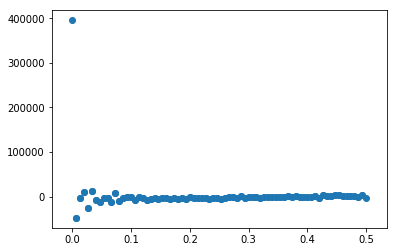

In [63]:
plt.scatter(abs(freqs), w)

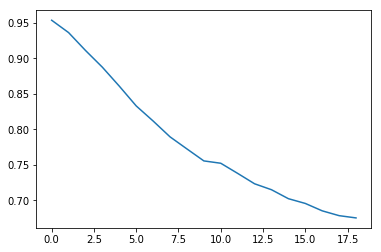

In [125]:
def autocorr(x, max_lag, steps):
    
    results = []
    
    for i in range(1, max_lag, steps):
        
        x_hat = np.append(np.zeros(i), x[:len(x)-i])
        results.append(np.corrcoef(x, x_hat)[1][0])
        
    return results

plt.plot(autocorr(x, 20, 1))

In [135]:
article_df.loc[0]

ArticleID                   048485a0
DOI                 10.1038/048485a0
Issue                           1247
Volume                            48
PageEnd                          508
PageStart                        485
PubYear                         1893
SortDate                  1893-09-21
Title        The British Association
Type                              ed
Journal                       Nature
Name: 0, dtype: object

## Step 2: Reading and Preprocessign XML Files

In [145]:
with open('data/nature/preprocessed/abstract_df.pickle', 'rb') as f:
        abstract_df = pickle.load(f)

In [149]:
abstract_df

,ArticleID,Abstract
0,048485a0,THE Nottingham meeting of the British Associat...
1,048508a0,I HAD hoped that the British Museum slander ca...
2,048509a0,BISHOP'S RING still continues very conspicuous...
3,048509b0,As the peculiarities of this season are receiv...
4,048509c0,"MR. W. SAVILLE-KENT, at present engaged as Com..."
...,...,...
395498,149145b0,"IN a recent paper, W. R. Wedel dealt with man'..."
395499,149146a0,"R. C. HAYES, acting director of the Dominion O..."
395500,149146b0,(\nMeeting marked with an asterisk is open to ...
395501,149146c0,APPLICATIONS are invited for the following app...


In [159]:
directory = 'data/nature/raw xml/'
zfile = zipfile.ZipFile(os.path.join(directory, os.listdir(directory)[0]))

for finfo in zfile.infolist():
        ifile = zfile.open(finfo)
        line_list = ifile.readlines()

In [171]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [169]:
line_list[np.argmax(['4402' in str(line) for line in line_list])]

b'<iss>4402</iss>\r\n'

In [161]:
os.listdir(directory)[0]

'nature_v173_n4402_xml.zip'

In [172]:
line_list

[b'<?xml version="1.0"?>\r\n',
 b'<!DOCTYPE headerx PUBLIC "-//NPG//DTD headerx//EN" "headerx.dtd">\r\n',
 b'<headerx>\r\n',
 b'<ArticleIdList>\r\n',
 b'<ArticleId>173508a0</ArticleId></ArticleIdList>\r\n',
 b'<pubfm>\r\n',
 b'<jtl>Nature</jtl>\r\n',
 b'<vol>173</vol>\r\n',
 b'<iss>4402</iss>\r\n',
 b'<idt>19540313</idt>\r\n',
 b'<categ id="categtxt"/>\r\n',
 b'<categtxt>Reports and other Publications</categtxt>\r\n',
 b'<pp><spn>508</spn><epn>508</epn></pp>\r\n',
 b'<issn>0028-0836</issn>\r\n',
 b'<cpg><cpy>1954</cpy><cpn>Nature Publishing Group</cpn></cpg>\r\n',
 b'<doi>10.1038/173508a0</doi>\r\n',
 b'</pubfm>\r\n',
 b'<fm>\r\n',
 b'<atl>Reports and other Publications</atl>\r\n',
 b'</fm>\r\n',
 b'<bdy>(not included in the monthly Books Supplement)\r\n',
 b'Great Britain and Ireland\r\n',
 b'Air Ministry : Meteorological Office. Averages of Temperature for Great Britain and Northern Ireland 1921-50. Pp. ii &plus; 36. (London : H.M. Stationery Office, 1953.) 2s. net. [121\r\n',
 b'Min

In [173]:
len(os.listdir(directory))

7867

In [190]:
os.listdir(directory)

['nature_v173_n4402_xml.zip',
 'nature_v18_n449_xml.zip',
 'nature_v260_n5554_xml.zip',
 'nature_v232_n5308_xml.zip',
 'nature_v485_n7400test-jo_xml.zip',
 'nature_v201_n4914_xml.zip',
 'nature_v57_n1476_xml.zip',
 'nature_v72_n1854_xml.zip',
 'nature_v57_n1468_xml.zip',
 'nature_v22_n554_xml.zip',
 'nature_v127_n3205_xml.zip',
 'nature_v78_n2034_xml.zip',
 'nature_v87_n2175_xml.zip',
 'nature_v12_n300_xml.zip',
 'nature_v110_n2772_xml.zip',
 'nature_v176_n4484_xml.zip',
 'nature_v43_n1121_xml.zip',
 'nature_v238_n5358_xml.zip',
 'nature_v258_n5531_xml.zip',
 'nature_v10_n237_xml.zip',
 'nature_v67_n1748_xml.zip',
 'nature_v158_n4018_xml.zip',
 'nature_v20_n501_xml.zip',
 'nature_v211_n5050_xml.zip',
 'nature_v369_n6478_xml.zip',
 'nature_v40_n1028_xml.zip',
 'nature_v373_n6512_xml.zip',
 'nature_v156_n3965_xml.zip',
 'nature_v88_n2202_xml.zip',
 'nature_v383_n6601_xml.zip',
 'nature_v104_n2611_xml.zip',
 'nature_v463_n7278_xml.zip',
 'nature_v39_n992_xml.zip',
 'nature_v109_n2738_xml.

In [20]:
def get_reference_mapping(filename, content):
    
    """
    Given XML filename and XML file, extract rid mappings and attribute data
    """
    
    mappings  = {}
    extracted = {}
    references = {}
    parsed    = xmltodict.parse(content.decode('UTF-8'))
    soup      = BeautifulSoup(content)

    if '@id' in parsed['article']:
        extracted['id']       = str(parsed['article']['@id'])
    if '@language' in parsed['article']:
        extracted['language'] = str(parsed['article']['@language'])
    if '@publish' in parsed['article']:
        extracted['publish']  = str(parsed['article']['@publish'])
    if '@relation' in parsed['article']:
        extracted['relation'] = str(parsed['article']['@relation'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('jtl' in parsed['article']['pubfm']):
                extracted['jtl']   = str(parsed['article']['pubfm']['jtl'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['vol']   = str(parsed['article']['pubfm']['vol'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('issue' in parsed['article']['pubfm']):
                extracted['issue'] = str(parsed['article']['pubfm']['issue'])

    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['doi']   = str(parsed['article']['pubfm']['doi'])
    
    if ('article' in parsed):
        if ('fm' in parsed['article']):
            if ('atl' in parsed['article']['fm']):
                extracted['title']   = str(parsed['article']['fm']['atl'])
     
    
    del parsed
    
    for bib in soup.find_all("bib"):
        
        try:
            reference_attr = {}
            
            reference_attr['title']   = str(bib.atl.contents[0])
            reference_attr['snm']     = str([i.contents[0] for i in bib.find_all('snm')])
            reference_attr['fnm']     = str([i.contents[0] for i in bib.find_all('fnm')])
            reference_attr['journal'] = str(bib.jtl.contents[0])
            reference_attr['year']    = str(bib.find_all('cd')[0].contents[0])

            references.update({bib.attrs['id']: reference_attr})
        
        except Exception as e:
            
            if DEBUG == True:
            
                print('='*50)
                print('Something is wrong with BeatifulSoup Tags: %s' % str(bib))
                for i in ['snm', 'fnm', 'jtl', 'year', 'atl']:
                    if len(bib.find_all(i)) == 0:
                        print('%s attribute is missing.' %i)
            
            else: pass
            
    
    references = {'metadata': extracted, 'references': references}
    
    try:
        with open('data/intermediate/references/%s' % (filename + '.json'), 'w') as f:
            f.write(json.dumps(references))
        return True
    
    except TypeError as e:
        #print('Some contents of the file %s is not serializable' % filename)
        raise e
        
        
def get_reference_text(filename, content):
    
    """
    Given XML filename and XML file, extract referencing text and reference metadata
    TODO: Compile all regex to make it faster
    
    Returns  {str(unique_paper_indentifier), list(preceeding_text)}
    """
    
    content   = content.decode('UTF-8')
    bibid     = re.findall(r'<bibr\srid=\"(.*?)\"\s*\/>', content)
    #bibtext   = re.findall(r"\s.*?<bibr\s", content)
    
    bibtext_intermediate = [s for s in sent_detector.tokenize(content)\
                               if re.search(r'<bibr\srid', s)]

    bibtext_intermediate = [s.split('</p>') for s in bibtext_intermediate]
    bibtext_intermediate = [item for sublist in bibtext_intermediate for item in sublist]

    bibtext_intermediate = [s for s in bibtext_intermediate if re.search(r'<bibr\srid', s)]
    text_counter         = [len(re.findall(r'<bibr\srid', s)) for s in bibtext_intermediate]

    bibtext = []

    for i, s in enumerate(bibtext_intermediate):
        while text_counter[i] != 0:
            bibtext.append(s)
            text_counter[i] -= 1
        
    
    assert(len(bibid) == len(bibtext)), "The bibid's and preceeding text don't match: " +\
                                        "for article %s\n" % filename +\
                                        "bibid: %s\n" %bibid +\
                                        "bibtext: %s\n" %bibtext
    
    with open('data/intermediate/tex_ref_mappings/%s' % (filename + '.json'), 'w') as f:
        f.write(json.dumps([{i[1]:i[0].split(' ')} for i in zip(bibid, bibtext)]))
    
    return 


In [22]:
def get_zips():
    
    """
    Function to extract relevant files from the filebase
    """
    
    citations = {}
    directory = 'data/nature/raw xml/'
    zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
    
    errored   = []
    #zfile     = zipfile.ZipFile(os.path.join(directory, zip_list[0]))
    
    for zfile in tqdm(zip_list):
        
        zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

        for finfo in zfile.infolist():

            if 'nature' in finfo.filename:

                try:
                    ifile = zfile.open(finfo)
                    content = ifile.read()
                    tex_ref_map = get_reference_text(finfo.filename, content)
                    ref_id_ref_map = get_reference_mapping(finfo.filename, content)

                    citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
                                                'ref_id_ref_map': ref_id_ref_map}
                except Exception as e:

                    print('Filename: %s, Zip:%s, Content:%s' % (finfo.filename,
                                                                zfile,
                                                                content))
                    errored.append({'Filename':finfo.filename,
                                    'Zip':zfile ,
                                    'Content': content})
                    #return content
                    #raise Exception
            
    return citations, errored
        
#papers, errored = get_zips()

In [4]:
%time

def get_zips_parallel_mapper(directory):
    
    """
    Function to extract relevant files from the filebase
    """
    
    try:
        
        zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
        errored   = []
        finfos    = []
        contents  = []

        for zfile in tqdm(zip_list):

            zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

            for finfo in zfile.infolist():

                if 'nature' in finfo.filename:
                    
                    ifile = zfile.open(finfo)
                    content = ifile.read()

                    finfos.append(finfo)
                    contents.append(zlib.compress(content))

        return finfos, contents
    
    except Exception as e:
        
        print('Could not read file from zip %s, file %s' % (zfile, finfo.name))
        
def get_zips_parallel_reducer(arg):
    
    try:
        finfo, content = arg[0], zlib.decompress(arg[1])
        del arg

        #citations = {}
        #tex_ref_map = get_reference_text(finfo.filename, content)
        #ref_id_ref_map = get_reference_mapping(finfo.filename, content)
        #citations[finfo.filename] = {'tex_ref_map': tex_ref_map,
        #                            'ref_id_ref_map': ref_id_ref_map}
        
        get_reference_text(finfo.filename, content)
        get_reference_mapping(finfo.filename, content)
        
        return True
    
    except Exception as e:
        
        #print('Could not extract references from %s' % finfo)
        return str(Exception)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [27]:
##TEST on one
DEBUG = False
directory     = 'data/nature/raw xml/'
finfos, contents = get_zips_parallel_mapper(directory)
get_zips_parallel_reducer((finfos[2], contents[2]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


True

In [29]:
%time
finfos, contents = get_zips_parallel_mapper(directory)
p = Pool(6)
success = p.map(get_zips_parallel_reducer, zip(finfos, contents))
error_rate = sum([1 if i == True else 0 for i in success])/len(success)
print ('%f of all processed files Succeeded' % error_rate)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



0.999939 of all processed files failed


In [25]:
sum([1 if i == True else 0 for i in success])

4320

In [22]:
with open('data/intermediate/paper_citations.pkl', 'wb') as f:
    pkl.dump(papers, f)

## Step 3: Grouping References Together

In [46]:
def build_ref_index(tex_ref_mappings, reference):

    inverse_tex_ref = {}
    
    for tex_refs in tex_ref_mappings:
        
        text, refs = list(tex_refs.items())[0]
        
        for ref in refs: 
            if ref in inverse_tex_ref:
                inverse_tex_ref[ref].append(text)
            else:
                inverse_tex_ref[ref] = [text]
    
    return inverse_tex_ref
    
def read_files():
    
    directory = 'data/intermediate/'
    tex_ref_mappings = []
    references       = []
    
    tex_ref_files = os.listdir(os.path.join(directory, 'tex_ref_mappings'))
    references_files = os.listdir(os.path.join(directory, 'references'))
    
    if len(tex_ref_files) != len(references_files):
        print('Not all text files have a references counterpart.\n'
              'Continuing with the files that do have a mapping')
    
    #file = tex_ref_files[1]
    
    for file in tqdm(tex_ref_files):
        #print(file)
        #print(tex_ref_mappings)
        
        with open(os.path.join(directory, 'tex_ref_mappings', file), 'r', encoding = 'UTF-8') as f0:

            try:
                with open(os.path.join(directory, 'references', file), 'r',  encoding = 'UTF-8') as f1:

                    tex_ref_mappings.append(json.loads(str(f0.read()),  encoding = 'UTF-8'))
                    references.append(json.loads(str(f1.read()),  encoding = 'UTF-8'))

            except IOError as e:
                print('References file %f not found.' % file)
    
    return tex_ref_mappings, references


In [47]:
tex_ref_mappings, references = read_files()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [128]:
references[1]['references']['b3']

{'fnm': "['V.']",
 'journal': 'Nature',
 'snm': "['Courtillot']",
 'title': 'Deccan flood basalts on Cretaceous/Tertiary boundary',
 'year': '1988'}

In [138]:
references_w_text = onur_json(tex_ref_mappings, references)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [3]:
nature_references_info = pd.read_hdf('data/nature/preprocessed/NatureReferencesInformation.hdf').set_index('DOI')
nature2references      = pd.read_hdf('data/nature/preprocessed/Nature2References.hdf')

In [21]:
nature2references.head()

,CitingArticleID,CitedArticleID
0,pub.1007899685,pub.1050061940
1,pub.1007899685,pub.1033662532
2,pub.1007899685,pub.1055023195
3,pub.1007899685,pub.1024775385
4,pub.1026639700,pub.1040537791


In [212]:
nature_references_info.head()

,ArticleID,PubYear,Title,Volume,Issue,Cites,Journal,NatureID
DOI,,,,,,,,
10.1038/166444b0,pub.1007899685,1950,Detection of Sugars on Paper Chromatograms,166,4219,3143,Nature,166444b0
10.1038/166117b0,pub.1026639700,1950,The Soil-Plate Method for Isolation of Fungi f...,166,4211,394,Nature,166117b0
10.1038/165514a0,pub.1039717355,1950,Reversible Dilation and Contraction by Changin...,165,4196,359,Nature,165514a0
10.1038/166780a0,pub.1011096023,1950,Cell Specificity of Histones,166,4227,280,Nature,166780a0
10.1038/166288a0,pub.1000041177,1950,Synthesis of Peptides in Enzymic Reactions inv...,166,4216,259,Nature,166288a0


In [16]:
references[0]['metadata']['doi']

'10.1038/nature20106'

In [35]:
nature_references_info[nature_references_info.index == references[0]['metadata']['doi']]['ArticleID'].values[0]

'pub.1027267416'

In [36]:
nature2references[nature2references['CitingArticleID'] == nature_references_info[nature_references_info.index == references[0]['metadata']['doi']]['ArticleID'].values[0]]

,CitingArticleID,CitedArticleID
6737792,pub.1027267416,pub.1030609599


In [161]:
def get_reference_map_0(nature2references, nature_references_info, doi):
    
    try:
        article_id = nature_references_info[nature_references_info.index == doi]['ArticleID'].values[0]
    
        references = nature2references[nature2references['CitingArticleID'] == article_id]
    
        references = pd.merge(references, nature_references_info,
                              how = 'left', left_on = 'CitedArticleID', right_on = 'ArticleID')
    
    except Exception as e:
        
        print('doi: %s' % doi)
        print(e)
        references = pd.DataFrame()
    
    return references

In [162]:
def get_reference_map_1(get_reference_map_1_input): 
    
    """
    NOTE: Improvements Todo: Force 1-1 mapping, add year and journal to increase map accuracy
    """
    
    reference, tex_ref_mapping = get_reference_map_1_input
    
    if 'doi' in reference['metadata']:
        doi = reference['metadata']['doi']

        references_0 = get_reference_map_0(nature2references, nature_references_info, doi).fillna('')

        references_1 = pd.DataFrame.from_dict(reference['references'], orient = 'index').fillna('')

        if (len(references_1) > 0) and (len(references_0) > 0):

            references_1['text'] = references_1.index.map(build_ref_index(tex_ref_mapping, reference))

            vect = TfidfVectorizer(min_df=1, stop_words="english")
            tfidf = vect.fit(list(references_0['Title']) + list(references_1['title']))

            vect_0 = vect.transform(list(references_0['Title']))
            vect_1 = vect.transform(list(references_1['title']))

            pairwise_similarity = vect_0 * vect_1.T 

            references_0['match_index'] = [i[0] for i in np.argmax(pairwise_similarity, axis = 1).tolist()]

            test_match = pd.merge(references_0,
                                  references_1.reset_index(),
                                  left_on = 'match_index',
                                  right_index = True, how = 'left').rename(columns = {'Title': 'title0',
                                                                                     'title': 'title1'})

            return test_match

    else:

        return pd.DataFrame()

In [165]:
matched_df = get_reference_map_1((references[1], tex_ref_mappings[1]))

In [12]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [166]:
matched_df[['ArticleID', 'title0', 'title1', 'text']]

,ArticleID,title0,title1,text
0,pub.1011515456,Kerguelen Hotspot Magma Output since 130 Ma,Kerguelen hotspot magma output since 130 Ma,"[But recent geochronological data<bibr rid=""b4..."
1,pub.1029752757,Deccan flood basalts and the Cretaceous/Tertia...,Deccan flood basalts on Cretaceous/Tertiary bo...,[The Siberian Traps at the Permian&ndash;Trias...
2,pub.1033167081,Mineralogy of subducted basaltic crust (MORB) ...,Mineralogy of subducted basaltic crust (MORB) ...,NaN
3,pub.1062550794,Synchrony and Causal Relations Between Permian...,Synchrony and causal relations between Permian...,[The Siberian Traps at the Permian&ndash;Trias...
4,pub.1000115762,Discrete alternating hotspot islands formed by...,Discrete alternating hotspot islands formed by...,"[Other models, such as solitary waves travelli..."
5,pub.1003389384,Whole-mantle versus layered mantle convection ...,Whole-mantle versus layered mantle convection ...,[\r\n<p>We performed the calculations using th...
6,pub.1011327470,Implications of mantle plume structure for the...,Implications of mantle plume structure for the...,[</descrip></suppobj>\r\n</suppinfo>\r\n<doi>1...
7,pub.1098792031,Mantle Plumes and their Record in Earth History,Excess temperature of mantle plumes: The role ...,NaN
8,pub.1047915559,A comparison of methods for the modeling of th...,A comparison of methods for the modeling of th...,[The distribution of the compositionally disti...
9,pub.1062549234,Double Flood Basalts and Plume Head Separation...,Double flood basalts and plume head separation...,[Plume head separation at the 660-km discontin...


In [ ]:

matched_df = pd.DataFrame()

for i in tqdm(range(500)):
    
    try:
        matched_df = matched_df.append(get_reference_map_1((references[i], tex_ref_mappings[i])))
    except Exception as e:
        pass

In [11]:
%%time

mp_input = zip(references, tex_ref_mappings)
p        = Pool(8)

matched_dfs = p.map(get_reference_map_1, mp_input)

doi: 10.1038/nature11182b
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11182b
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature.2017.21620
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature22808
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature01206
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11870_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature21729
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11847_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11942_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11893_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11977_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature21898
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11047a
index 0 is out of bounds for axis 0

In [12]:
len(matched_dfs)

16393

In [23]:
with open('data/intermediate/matched_dfs_raw.pkl', 'wb') as f:
    pkl.dump(matched_dfs, f)

In [3]:
with open('data/intermediate/matched_dfs_raw.pkl', 'rb') as f:
    matched_dfs = pkl.load(f)

In [156]:
matched_dfs = pd.concat(matched_dfs)

In [4]:
matched_dfs

In [32]:
matched_dfs = pd.DataFrame(matched_dfs.groupby('ArticleID')\
                                 .apply(lambda x: list(x['text'].values))).rename(columns = {0: 'text'})

In [158]:
matched_dfs.head()

,CitingArticleID,CitedArticleID,ArticleID,PubYear,title0,Volume,Issue,Cites,Journal,NatureID,match_index,index,title1,journal,fnm,year,snm,text
0,pub.1003700634,pub.1011515456,pub.1011515456,2002,Kerguelen Hotspot Magma Output since 130 Ma,43,7,224,Journal of Petrology,,2,b7,Kerguelen hotspot magma output since 130 Ma,J. Petrol.,['M. F.'],2002,['Coffin'],"[But recent geochronological data<bibr rid=""b4..."
1,pub.1003700634,pub.1029752757,pub.1029752757,1988,Deccan flood basalts and the Cretaceous/Tertia...,333,6176,333,Nature,333843a0,13,b3,Deccan flood basalts on Cretaceous/Tertiary bo...,Nature,['V.'],1988,['Courtillot'],[The Siberian Traps at the Permian&ndash;Trias...
2,pub.1003700634,pub.1033167081,pub.1033167081,2001,Mineralogy of subducted basaltic crust (MORB) ...,190,1-2,185,Earth and Planetary Science Letters,,5,b24,Mineralogy of subducted basaltic crust (MORB) ...,Earth Planet. Sci. Lett.,"['S.', 'E.', 'T.']",2001,"['Ono', 'Ito', 'Katsura']",NaN
3,pub.1003700634,pub.1062550794,pub.1062550794,1995,Synchrony and Causal Relations Between Permian...,269,5229,425,Science,,14,b2,Synchrony and causal relations between Permian...,Science,"['P. R.', 'Z.', 'M. A.', 'M. T.', 'A. R.']",1995,"['Renne', 'Zichao', 'Richards', 'Black', 'Basu']",[The Siberian Traps at the Permian&ndash;Trias...
4,pub.1003700634,pub.1000115762,pub.1000115762,1999,Discrete alternating hotspot islands formed by...,397,6720,59,Nature,17584,20,b15,Discrete alternating hotspot islands formed by...,Nature,"['C. F.', 'D.']",1999,"['Hieronymus', 'Bercovici']","[Other models, such as solitary waves travelli..."


In [34]:
matched_dfs['count'] = matched_dfs.apply(lambda x: len(x['text']), axis = 1 )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb481d3550>]],
      dtype=object)

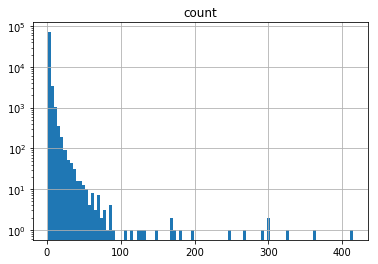

In [47]:
matched_dfs[matched_dfs['count'] > 1].hist(bins = 100, log = True)

In [37]:
nature_references_info[nature_references_info['ArticleID'] == 'pub.1020281098']

,ArticleID,PubYear,Title,Volume,Issue,Cites,Journal,NatureID
DOI,,,,,,,,
10.1107/s0907444904019158,pub.1020281098,2004,Coot: model-building tools for molecular graphics,60,12,18563,"Acta Crystallographica Section D, Structural B...",None


In [48]:
def flatten(l):
    flat_list = []
    for sublist in l:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
    return flat_list

matched_dfs['clean_text'] = matched_dfs['text'].apply(flatten)



In [49]:
len(matched_dfs)

318577

In [50]:
matched_dfs['clean_text'] = matched_dfs['clean_text'].apply(lambda x: [BeautifulSoup(i, "lxml").text for i in x])
matched_dfs['count'] = matched_dfs['clean_text'].apply(lambda x: len(x))
matched_dfs = matched_dfs[matched_dfs['count'] != 0]

In [51]:
matched_dfs.to_csv('data/intermediate/matched_dfs.csv')

In [58]:
matched_dfs.sort_values('count')

,text,count,clean_text
ArticleID,,,
pub.1027893469,[[\n<p>&agr;-Synuclein is an abundant presynap...,1,[&agr;-Synuclein is an abundant presynaptic pr...
pub.1025563456,"[[Here we show that, in both humans and <i>Xen...",1,"[Here we show that, in both humans and Xenopus..."
pub.1045348105,[[The strong increase of the soliton period is...,1,[The strong increase of the soliton period is ...
pub.1045347959,"[[This technique, originally suggested by Butc...",1,"[This technique, originally suggested by Butch..."
pub.1025564511,[[GPR68 is expressed in many tissues and has b...,1,[GPR68 is expressed in many tissues and has be...
...,...,...,...
pub.1019779527,"[[Using this phase information, the structural...",365,"[Using this phase information, the structural ..."
pub.1012753217,[[Molecular replacement was performed using th...,372,[Molecular replacement was performed using the...
pub.1020777046,[[Structure determination was performed with P...,452,[Structure determination was performed with PH...


In [16]:
matched_dfs = pd.read_csv('data/intermediate/matched_dfs.csv')

In [10]:
len(matched_dfs[matched_dfs['text'].str.contains('rid=')])

304447

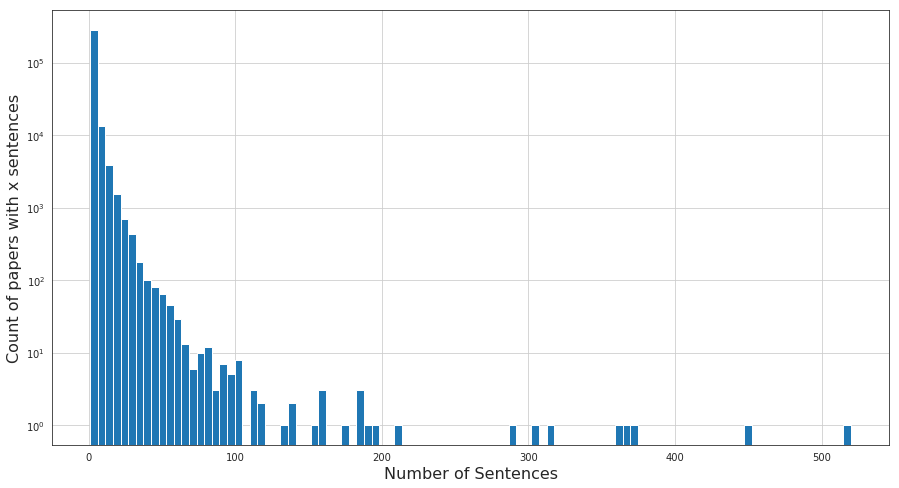

In [82]:
plt.figure(figsize=(15,8))
plt.hist(matched_dfs['count'], bins=100, log = True)
#plt.xticks(range(1,21))
plt.xlabel('Number of Sentences', fontsize=16)
plt.ylabel('Count of papers with x sentences', fontsize=16)
plt.grid()
plt.show()

In [15]:
matched_dfs[~matched_dfs['ArticleID'].isna()]

,ArticleID,text,count,clean_text
1,pub.1000000277,[['A detailed comparison of residues involved ...,1,['A detailed comparison of residues involved i...
2,pub.1000000280,"[['Also, the epigenetic stability of human ES ...",1,"['Also, the epigenetic stability of human ES c..."
3,pub.1000000588,[['Hospital and clinic HTC had similar costs (...,1,['Hospital and clinic HTC had similar costs (&...
4,pub.1000000718,"[['<b>e</b>, Allele-based pleiotropy of <i>IL6...",2,"['e, Allele-based pleiotropy of IL6R 358Asp (r..."
5,pub.1000000866,"[['However, structural<bibr rid=""b39 b40 b41 b...",1,"['However, structural and biochemical studies ..."
...,...,...,...,...
304442,pub.1121819253,[['Lineage-affiliated transcription factors<bi...,4,['Lineage-affiliated transcription factors wit...
304443,pub.1121819356,[['\r\n<p>In order to investigate a yolk-sac c...,1,['In order to investigate a yolk-sac contribut...
304444,pub.1121824901,[['Despite the clear upper limit in observed a...,1,['Despite the clear upper limit in observed ax...
304445,pub.1122267945,[['The so-called photon-dominated or photodiss...,7,['The so-called photon-dominated or photodisso...


In [17]:
matched_dfs = pd.merge(nature_references_info.reset_index(), matched_dfs, right_on = 'ArticleID', left_on = 'ArticleID')

In [18]:
matched_dfs.to_csv('data/intermediate/matched_dfs_merged.csv', index = False)

In [28]:
matched_dfs.head()

,ArticleID,PubYear,Title,Volume,Issue,Cites,Journal,NatureID,text,count,clean_text
0,pub.1002147798,1950,Deformations in the Crystal Structures of Anti...,166,4221,105,Nature,166523a0,[['It is well known that the crystallographic ...,1,['It is well known that the crystallographic d...
1,pub.1053335653,1950,Upper Limit of Frequency for Human Hearing,166,4222,75,Nature,166571b0,"[['\r\n<p>In humans, ultrasound can be detecte...",1,"['In humans, ultrasound can be detected via bo..."
2,pub.1037944905,1950,Haploid Plants of Solanum demissum,166,4227,28,Nature,166795a0,"[['Second, haploids can be induced from rare i...",1,"['Second, haploids can be induced from rare in..."
3,pub.1046899436,1950,The Liquid–Solid Transition in Helium Near Abs...,165,4204,26,Nature,165829a0,"[['The only exception is helium, which can rem...",1,"['The only exception is helium, which can rema..."
4,pub.1003128813,1950,Odour Trails of Acanthomyops fuliginosus,166,4212,25,Nature,166154a0,"[['However, previous research has found no evi...",1,"['However, previous research has found no evid..."


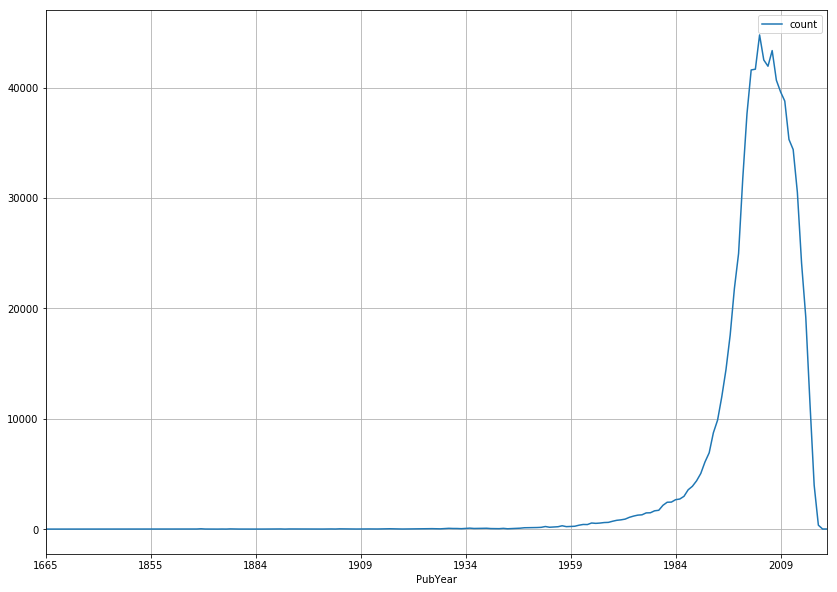

In [25]:
matched_dfs[['count', 'PubYear']].groupby('PubYear').sum().plot(figsize = (14, 10), grid = True)

In [111]:
matched_dfs.loc[220033]['clean_text']

["['This model was combined into a single protein chain",
 'built and refined iteratively against native data using ARP-WARP',
 'COOT',
 "and PHENIX refine.'",
 "'This model was built and refined iteratively using COOT and PHENIX refine.'",
 "'Additional &agr;-helical density for the M domain was observed and &agr;M1–&agr;M1b (residues 327–352) and &agr;M2–&agr;M4 (residues 374–431) were built by several rounds of manual model rebuilding in COOT and refinement (see below) in CNS.'",
 "'An initial model of HEN1 was manually built with the programs O and Coot using the locations of SeMet positions as guides.'",
 "'The structure was solved by molecular replacement",
 'subsequent model building and refinement (including TLS refinement) was performed with COOT and CCP4 (refs 31',
 "32).'",
 "'The atomic model was built manually with Coot and refined with PHENIX.'",
 "'The initial structure model was completed and improved through iterative refinement in Phenix and manual rebuilding of all t

In [48]:
citation_graph = nx.from_pandas_edgelist(nature2references, source = 'CitingArticleID', target = 'CitedArticleID')

In [50]:
citation_node_degree = pd.DataFrame(citation_graph.degree)

In [53]:
citation_node_degree = citation_node_degree.rename(columns = {0:'ArticleID', 1: 'Degree'})

In [54]:
matched_dfs = pd.merge(citation_node_degree, matched_dfs)

### Creating the JSON in the format the Onur requires

In [ ]:
def onur_json(tex_ref_mappings, references):
    
    references_w_text = references.copy()
    
    for i in tqdm(range(len(references_w_text))):
        
        paper = tex_ref_mappings[i]

        #print (paper)
        for tex_ref_mapping in paper:

            #print(tex_ref_mapping.values())

            for ref_id in list(tex_ref_mapping.values())[0]:

                if 'references' in references_w_text[i]:
                    
                    if ref_id in references_w_text[i]['references']:

                        references_w_text[i]['references'][ref_id].update({'text' :list(tex_ref_mapping.keys())[0]})
                        
                    else:
                        references_w_text[i]['references'][ref_id] = {'text' :list(tex_ref_mapping.keys())[0]}

    return references

In [ ]:
def get_zips_parallel_reducer(arg):
    
    try:
        finfo, content = arg[0], zlib.decompress(arg[1])
        del arg
        
        get_reference_text(finfo.filename, content)
        get_reference_mapping(finfo.filename, content)
        
        return True
    
    except Exception as e:
        
        #print('Could not extract references from %s' % finfo)
        return str(Exception)

In [ ]:
def flatten(l):
    flat_list = []
    for sublist in l:
        if type(sublist) == list:
            for item in sublist:
                flat_list.append(item)
    return flat_list

In [6]:
nature_references_info['DOI'] = nature_references_info.index
nature_references_info.head()

,ArticleID,PubYear,Title,Volume,Issue,Cites,Journal,NatureID,DOI
DOI,,,,,,,,,
10.1038/166444b0,pub.1007899685,1950,Detection of Sugars on Paper Chromatograms,166,4219,3143,Nature,166444b0,10.1038/166444b0
10.1038/166117b0,pub.1026639700,1950,The Soil-Plate Method for Isolation of Fungi f...,166,4211,394,Nature,166117b0,10.1038/166117b0
10.1038/165514a0,pub.1039717355,1950,Reversible Dilation and Contraction by Changin...,165,4196,359,Nature,165514a0,10.1038/165514a0
10.1038/166780a0,pub.1011096023,1950,Cell Specificity of Histones,166,4227,280,Nature,166780a0,10.1038/166780a0
10.1038/166288a0,pub.1000041177,1950,Synthesis of Peptides in Enzymic Reactions inv...,166,4216,259,Nature,166288a0,10.1038/166288a0


#### Test on two papers

In [12]:
matched_df = get_reference_map_onur((references[1], tex_ref_mappings[1]))

In [13]:
matched_dfs = matched_df.append(get_reference_map_onur((references[2], tex_ref_mappings[2]))).set_index('citing_doi')

In [14]:
matched_dfs

,CitingArticleID,CitedArticleID,ArticleID,PubYear,Title - matched_to,Volume,Issue,Cites,Journal,NatureID,DOI,index,snm,Title - matched_from,year,journal,fnm,text
citing_doi,,,,,,,,,,,,,,,,,,
10.1038/nature03697,pub.1003700634,pub.1011515456,pub.1011515456,2002,Kerguelen Hotspot Magma Output since 130 Ma,43,7,224,Journal of Petrology,,10.1093/petrology/43.7.1121,b7,['Coffin'],Kerguelen hotspot magma output since 130 Ma,2002,J. Petrol.,['M. F.'],"[But recent geochronological data<bibr rid=""b4..."
10.1038/nature03697,pub.1003700634,pub.1029752757,pub.1029752757,1988,Deccan flood basalts and the Cretaceous/Tertia...,333,6176,333,Nature,333843a0,10.1038/333843a0,b3,['Courtillot'],Deccan flood basalts on Cretaceous/Tertiary bo...,1988,Nature,['V.'],[The Siberian Traps at the Permian&ndash;Trias...
10.1038/nature03697,pub.1003700634,pub.1033167081,pub.1033167081,2001,Mineralogy of subducted basaltic crust (MORB) ...,190,1-2,185,Earth and Planetary Science Letters,,10.1016/s0012-821x(01)00375-2,b24,"['Ono', 'Ito', 'Katsura']",Mineralogy of subducted basaltic crust (MORB) ...,2001,Earth Planet. Sci. Lett.,"['S.', 'E.', 'T.']",NaN
10.1038/nature03697,pub.1003700634,pub.1062550794,pub.1062550794,1995,Synchrony and Causal Relations Between Permian...,269,5229,425,Science,,10.1126/science.269.5229.1413,b2,"['Renne', 'Zichao', 'Richards', 'Black', 'Basu']",Synchrony and causal relations between Permian...,1995,Science,"['P. R.', 'Z.', 'M. A.', 'M. T.', 'A. R.']",[The Siberian Traps at the Permian&ndash;Trias...
10.1038/nature03697,pub.1003700634,pub.1000115762,pub.1000115762,1999,Discrete alternating hotspot islands formed by...,397,6720,59,Nature,17584,10.1038/17584,b15,"['Hieronymus', 'Bercovici']",Discrete alternating hotspot islands formed by...,1999,Nature,"['C. F.', 'D.']","[Other models, such as solitary waves travelli..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10.1038/nature01599,pub.1047617530,pub.1046838763,pub.1046838763,2000,A dynamic duo of microtubule modulators,2,1,15,Nature Cell Biology,71394,10.1038/71394,b34,['Heald'],A dynamic duo of microtubule regulators,1999,Nature Cell Biol.,['R.'],[These proteins could regulate the length of s...
10.1038/nature01599,pub.1047617530,pub.1018459115,pub.1018459115,2002,Mad2 and BubR1 Function in a Single Checkpoint...,13,10,80,Molecular Biology of the Cell,,10.1091/mbc.e02-03-0137,b61,"['Shannon', 'Canman', 'Salmon']",Mad2 and BubR1 function in a single checkpoint...,2002,Mol. Biol. Cell,"['K. B.', 'J. C.', 'E. D.']","[Accordingly, different experiments have led t..."
10.1038/nature01599,pub.1047617530,pub.1032265523,pub.1032265523,2002,Nuclear Envelope Breakdown Proceeds by Microtu...,108,1,310,Cell,,10.1016/s0092-8674(01)00627-4,b63,"['Beaudouin', 'Gerlich', 'Daigle', 'Eils', 'El...",Nuclear envelope breakdown proceeds by microtu...,2002,Cell,"['J.', 'D.', 'N.', 'R.', 'J.']","[We speculate that, as in metaphase, these thr..."


In [15]:
papers = {k: g.to_dict(orient='records') for k, g in matched_dfs.groupby(level=0)}

In [16]:
for reference in references: 
    
    if 'doi' in reference['metadata']:
        
        if reference['metadata']['doi'] in papers:
            
            papers[reference['metadata']['doi']] = {'metadata' : reference['metadata'],
                                                'references': papers[reference['metadata']['doi']]}

In [17]:
reference

{'metadata': {'doi': '10.1038/nature06234',
  'id': 'nature06234',
  'jtl': 'Nature',
  'language': 'eng',
  'publish': 'issue',
  'relation': 'no',
  'title': 'Controlling cavity reflectivity with a single quantum dot',
  'vol': '450'},
 'references': {'b1': {'fnm': "['D.']",
   'journal': 'Phys. Rev. Lett.',
   'snm': "['Englund']",
   'title': 'Controlling the spontaneous emission rate of single quantum dots in a two-dimensional photonic crystal',
   'year': '2005'},
  'b10': {'fnm': "['K. M.']",
   'journal': 'Nature',
   'snm': "['Birnbaum']",
   'title': 'Photon blockade in an optical cavity with one trapped atom',
   'year': '2005'},
  'b11': {'fnm': "['A.']",
   'journal': 'Phys. Rev. Lett.',
   'snm': "['Rauschenbeutel']",
   'title': 'Coherent operation of a tunable quantum phase gate in cavity QED',
   'year': '1999'},
  'b12': {'fnm': "['G.']",
   'journal': 'Nature',
   'snm': "['Nogues']",
   'title': 'Seeing a single photon without destroying it',
   'year': '1999'},
  '

In [49]:
len(papers)

14274

In [20]:
nature_references_info.loc['10.1038/nature01599']

ArticleID         pub.1047617530
PubYear                     2003
Title              Cell division
Volume                       422
Issue                       6933
Cites                        216
Journal                   Nature
NatureID             nature01599
DOI          10.1038/nature01599
Name: 10.1038/nature01599, dtype: object

In [21]:
%%time

mp_input = zip(references, tex_ref_mappings)
p        = Pool(8)

matched_dfs = p.map(get_reference_map_onur, mp_input)

doi: 10.1038/nature11182b
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11182b
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature.2017.21620
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature22808
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature01206
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11870_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature21729
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11847_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11942_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11893_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11977_techniques
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature21898
index 0 is out of bounds for axis 0 with size 0
doi: 10.1038/nature11047a
index 0 is out of bounds for axis 0

Process ForkPoolWorker-7:
Process ForkPoolWorker-8:
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bo

In [39]:
with open('data/intermediate/matched_dfs_raw.pkl', 'rb') as f:
    matched_dfs = pkl.load(f)

In [40]:
matched_dfs = pd.concat(matched_dfs).set_index('citing_doi')

In [41]:
matched_dfs['text'] = matched_dfs['text'].fillna('')

In [42]:
matched_dfs['clean_text'] = matched_dfs['text'].apply(lambda x: [BeautifulSoup(i, "lxml").text for i in x])
matched_dfs['count'] = matched_dfs['clean_text'].apply(lambda x: len(x))
#matched_dfs = matched_dfs[matched_dfs['count'] != 0]

In [43]:
papers = {k: g.to_dict(orient='records') for k, g in tqdm(matched_dfs.groupby(level=0))}

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [50]:
for reference in references: 
    
    if 'doi' in reference['metadata']:
        
        if reference['metadata']['doi'] in papers:
            
            papers[reference['metadata']['doi']] = {'metadata' : reference['metadata'],
                                                'references': papers[reference['metadata']['doi']]}

In [47]:
with open('data/intermediate/matched.jsons', 'w') as f:

        for index, paper in papers.items():

            f.write('\n')
            f.write(json.dumps({index:paper}))

In [ ]:
papers['10.1038/nature06452']

In [10]:
with open('data/intermediate/matched.jsons', 'r') as f:

    for i, line in enumerate(f.readlines()):
        
        try:
            unit_paper_dict = json.loads(line)
        
        except json.JSONDecodeError as e:
            
            print(e)
            print(i)

Expecting value: line 2 column 1 (char 1)
0


In [11]:
unit_paper_dict

{'10.1038/nature09207': {'metadata': {'doi': '10.1038/nature09207',
   'id': 'nature09207',
   'jtl': 'Nature',
   'language': 'eng',
   'relation': 'no',
   'title': 'Microtubule nucleating -TuSC assembles structures with 13-fold microtubule-like symmetry',
   'vol': '466'},
  'references': [{'ArticleID': 'pub.1010121551',
    'CitedArticleID': 'pub.1010121551',
    'Cites': 165,
    'CitingArticleID': 'pub.1030133211',
    'DOI': '10.1083/jcb.100.4.1185',
    'Issue': '4',
    'Journal': 'The Journal of Cell Biology',
    'NatureID': '',
    'PubYear': 1985,
    'Title - matched_from': 'Influence of the centrosome on the structure of nucleated microtubules',
    'Title - matched_to': 'Influence of the centrosome on the structure of nucleated microtubules.',
    'Volume': '100',
    'clean_text': ['However, microtubules nucleated in cells mostly have 13 protofilaments, suggesting that &ggr;-tubulin complexes constrain microtubule geometry.',
     'We propose that a &ggr;-TuSC assembly

### Getting original text

In [70]:
def get_text_mapping(filename, content):
    
    """
    Given XML filename and XML file, extract rid mappings and attribute data
    """
    
    mappings  = {}
    extracted = {}
    references = {}
    parsed    = xmltodict.parse(content.decode('UTF-8'))
    soup      = BeautifulSoup(content)

    if '@id' in parsed['article']:
        extracted['id']       = str(parsed['article']['@id'])
    if '@language' in parsed['article']:
        extracted['language'] = str(parsed['article']['@language'])
    if '@publish' in parsed['article']:
        extracted['publish']  = str(parsed['article']['@publish'])
    if '@relation' in parsed['article']:
        extracted['relation'] = str(parsed['article']['@relation'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('jtl' in parsed['article']['pubfm']):
                extracted['jtl']   = str(parsed['article']['pubfm']['jtl'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['vol']   = str(parsed['article']['pubfm']['vol'])
    
    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('issue' in parsed['article']['pubfm']):
                extracted['issue'] = str(parsed['article']['pubfm']['issue'])

    if ('article' in parsed):
        if ('pubfm' in parsed['article']):
            if ('vol' in parsed['article']['pubfm']):
                extracted['doi']   = str(parsed['article']['pubfm']['doi'])
    
    if ('article' in parsed):
        if ('fm' in parsed['article']):
            if ('atl' in parsed['article']['fm']):
                extracted['title']   = str(parsed['article']['fm']['atl'])
     
    
    del parsed
    
    #print(len(soup.find_all("bdy")))
    
    text = ''
    
    for bib in soup.find_all("bdy"):
        
        #print(bib.text)
        
        text += bib.text
            
    
    references = {'metadata': papers[extracted['doi']], 'text': text}
    
    try:
        with open('data/intermediate/full_text_mappings/%s' % (filename + '.json'), 'w') as f:
            f.write(json.dumps(references))
        return True
    
    except TypeError as e:
        #print('Some contents of the file %s is not serializable' % filename)
        raise e
        
        
def get_zips_parallel_reducer(arg):
    
    try:
        finfo, content = arg[0], zlib.decompress(arg[1])
        del arg

        get_text_mapping(finfo.filename, content)
        
        return True
    
    except Exception as e:
        
        print('Could not extract references from %s' % finfo)
        return str(Exception)

    
def get_zips_parallel_mapper(directory):
    
    """
    Function to extract relevant files from the filebase
    """
    
    try:
        
        zip_list  = [i for i in os.listdir(directory) if 'supp_xml' not in i]
        errored   = []
        finfos    = []
        contents  = []

        for zfile in tqdm(zip_list):

            zfile     = zipfile.ZipFile(os.path.join(directory, zfile))

            for finfo in zfile.infolist():

                if 'nature' in finfo.filename:
                    
                    ifile = zfile.open(finfo)
                    content = ifile.read()

                    finfos.append(finfo)
                    contents.append(zlib.compress(content))

        return finfos, contents
    
    except Exception as e:
        
        print('Could not read file from zip %s, file %s' % (zfile, finfo.name))
              

In [71]:
DEBUG = False
directory     = 'data/nature/raw xml/'
#finfos, contents = get_zips_parallel_mapper(directory)
get_zips_parallel_reducer((finfos[2], contents[2]))



True

In [62]:
papers['10.1038/nature04206']

{'metadata': {'doi': '10.1038/nature04206',
  'id': 'nature04206',
  'jtl': 'Nature',
  'language': 'eng',
  'publish': 'issue',
  'relation': 'no',
  'title': 'Observation of spin Coulomb drag in a two-dimensional electron gas',
  'vol': '437'},
 'references': [{'ArticleID': 'pub.1005015903',
   'CitedArticleID': 'pub.1005015903',
   'Cites': 889,
   'CitingArticleID': 'pub.1023679984',
   'DOI': '10.1007/978-3-662-05003-3',
   'Issue': '',
   'Journal': '',
   'NatureID': '',
   'PubYear': 2002,
   'Title - matched_from': 'Experimental observation of the spin Hall effect in a two-dimensional spin-orbit coupled semiconductor system',
   'Title - matched_to': 'Semiconductor Spintronics and Quantum Computation',
   'Volume': '',
   'clean_text': ['(The recently observed spin Hall effect also involves the counterflow of spin populations, and so should be damped by SCD.)'],
   'count': 1,
   'fnm': "['J.', 'B.', 'J.', 'T.']",
   'index': 'b12',
   'journal': 'Phys. Rev. Lett.',
   'snm': 

In [72]:
%time
finfos, contents = get_zips_parallel_mapper(directory)
p = Pool(7)
success = p.map(get_zips_parallel_reducer, zip(finfos, contents))
error_rate = sum([1 if i == True else 0 for i in success])/len(success)
print ('%f of all processed files Succeeded' % error_rate)

Could not extract references from <ZipInfo filename='nature02811.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1321 compress_size=691>
Could not extract references from <ZipInfo filename='nature15633.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=11935 compress_size=4443>
Could not extract references from <ZipInfo filename='nature.2015.18351.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8812 compress_size=3774>
Could not extract references from <ZipInfo filename='nature.2015.18431.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=10598 compress_size=4411>
Could not extract references from <ZipInfo filename='nature.2015.18432.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=9529 compress_size=4061>
Could not extract references from <ZipInfo filename='nature.2015.18440.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8319 compress_size=3696>
Could not extract references from <ZipInfo filename='nature.2015.18441.xml' compr

Could not extract references from <ZipInfo filename='nature11426.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=4955 compress_size=1512>
Could not extract references from <ZipInfo filename='nature14199.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=13562 compress_size=5336>
Could not extract references from <ZipInfo filename='nature14201.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=11130 compress_size=4109>
Could not extract references from <ZipInfo filename='nature11454.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=2189 compress_size=1028>
Could not extract references from <ZipInfo filename='nature11455.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=2754 compress_size=1136>
Could not extract references from <ZipInfo filename='nature04354.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=9073 compress_size=3555>
Could not extract references from <ZipInfo filename='nature04355.xml' compress_type=deflate filemode='-r

Could not extract references from <ZipInfo filename='nature14531.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=13349 compress_size=4939>
Could not extract references from <ZipInfo filename='nature.2015.17651.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=9615 compress_size=4174>
Could not extract references from <ZipInfo filename='nature12456.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=11127 compress_size=4479>
Could not extract references from <ZipInfo filename='nature12457.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=12580 compress_size=4679>
Could not extract references from <ZipInfo filename='nature12458.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=13834 compress_size=5166>
Could not extract references from <ZipInfo filename='nature12459.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=10880 compress_size=4060>
Could not extract references from <ZipInfo filename='nature22807.xml' compress_type=deflate fil

Could not extract references from <ZipInfo filename='nature.2017.22694.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=10838 compress_size=4430>
Could not extract references from <ZipInfo filename='nature.2017.22731.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=6069 compress_size=2748>
Could not extract references from <ZipInfo filename='nature.2017.22736.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8487 compress_size=3639>
Could not extract references from <ZipInfo filename='nature.2017.22737.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=13236 compress_size=5323>
Could not extract references from <ZipInfo filename='nature08846.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8569 compress_size=1924>
Could not extract references from <ZipInfo filename='nature08847.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1627 compress_size=824>
Could not extract references from <ZipInfo filename='nature10884.xml' compress_ty

Could not extract references from <ZipInfo filename='nature25994.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1696 compress_size=874>
Could not extract references from <ZipInfo filename='nature24139.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=13590 compress_size=5072>
Could not extract references from <ZipInfo filename='nature24141.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=12505 compress_size=4800>
Could not extract references from <ZipInfo filename='nature.2017.22648.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8629 compress_size=3669>
Could not extract references from <ZipInfo filename='nature.2017.22655.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=9432 compress_size=4034>
Could not extract references from <ZipInfo filename='nature.2017.22667.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=7429 compress_size=3359>
Could not extract references from <ZipInfo filename='nature26164.xml' compress_type=def

Could not extract references from <ZipInfo filename='nature15216.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=11917 compress_size=4750>
Could not extract references from <ZipInfo filename='nature15217.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=12449 compress_size=4876>
Could not extract references from <ZipInfo filename='nature15630.xml' compress_type=deflate filemode='-rwxrwxr-x' file_size=16612 compress_size=5918>
Could not extract references from <ZipInfo filename='nature.2015.18381.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=7195 compress_size=3131>
Could not extract references from <ZipInfo filename='nature.2015.18391.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=8019 compress_size=3607>
Could not extract references from <ZipInfo filename='nature00951.xml' compress_type=deflate filemode='-rw-rw-r--' file_size=1466 compress_size=749>
Could not extract references from <ZipInfo filename='nature11191.xml' compress_type=deflate 

Process ForkPoolWorker-8:
Process ForkPoolWorker-12:
Process ForkPoolWorker-9:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run(

In [84]:
def combine_jsons(directory = 'data/intermediate/full_text_mappings',
                  target = 'data/intermediate/matched_full_text.jsons'):

    
    with open (target, 'w') as f_to:
        for file in tqdm(os.listdir(directory)):
            with open(os.path.join(directory, file), 'r') as f_from:
                f_to.write(f_from.read() + '\n')
                
            
    
    return True

In [85]:
combine_jsons()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


True

In [94]:
with open('data/intermediate/matched_full_text.jsons', 'r') as f:
    
    print(len(f.readlines()))

14286


In [91]:
line = json.loads(line)

In [92]:
line

{'metadata': {'metadata': {'doi': '10.1038/nature16166',
   'id': 'nature16166',
   'jtl': 'Nature',
   'language': 'eng',
   'relation': 'no',
   'title': 'Substantial contribution of extrinsic risk factors to cancer development',
   'vol': '529'},
  'references': [{'ArticleID': 'pub.1035931121',
    'CitedArticleID': 'pub.1035931121',
    'Cites': 646,
    'CitingArticleID': 'pub.1037786036',
    'DOI': '10.1038/bjc.1991.210',
    'Issue': '6',
    'Journal': 'British Journal of Cancer',
    'NatureID': 'bjc.1991.210',
    'PubYear': 1991,
    'Title - matched_from': 'Cancers of the prostate and breast among Japanese and white immigrants in Los Angeles County',
    'Title - matched_to': 'Cancers of the prostate and breast among Japanese and white immigrants in Los Angeles County',
    'Volume': '63',
    'clean_text': ['Particularly, for breast and prostate cancers, it has long been observed that large international geographical variations exist in their incidence rates (for example,